# Titanic Survival challenge
## Overview
Use machine learning to predict which passengers survived the Titanic Shipwreck
Build a predictive model that can accurately determine which passengers survived the shipwreck based on a set of features, such as age, gender, class, and other personal attributes
### TODO
1. Load the data into a `pandas` dataframe
2. `Train` a basic machine learning Model
3. `Evaluate` the model
4. `Create`  a submission file  for the challenge

In [44]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve,auc,mean_squared_error,r2_score,f1_score,roc_auc_score,ConfusionMatrixDisplay,classification_report,accuracy_score,precision_score,recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

### Load and Inspect the data

In [45]:
#loading the train dataset
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

#Display the first few rows of the datasets and their shape
display('Train',train.head(),train.shape,'test',test.head(),test.shape)

'Train'

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


(891, 12)

'test'

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


(418, 11)

In [46]:
#check column types & missing values
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## Data Cleaning

### Check missing values

In [47]:
#Are there missing values in the train dataset?
print(f'There are {train.isna().sum()} missing values in the data')
#check missing values by percentage
print(f'There are {train.isnull().mean()*100} missing values in the data')

There are PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64 missing values in the data
There are PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64 missing values in the data


In [48]:
## Categorical columns
#drop missing values in column Embarked since they are only 2
train.dropna(subset='Embarked',inplace=True)

#drop column cabin since it has 77% of the data missing
train.drop(columns='Cabin',axis=1,inplace=True)

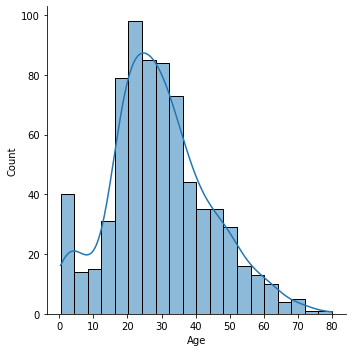

In [49]:
#check continous column age how its distributed using histogram 
sns.displot(train['Age'],kde=True)
train['Age'].skew() #0.388

#fill mising with median since data is skewed
age_median= train['Age'].median()
train['Age'].fillna(age_median,inplace=True)


In [50]:
#No missing values now
train.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

### check duplicates

In [51]:
train.duplicated().sum() # no duplicates

0

## EDA

In [52]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked'],
      dtype='object')

### plot for continous variables 

In [53]:
def plot_continous(df,column):
    fig,ax = plt.subplots(figsize=(12,8))
    sns.histplot(df[column],kde=True)
    ax.set(xlabel = column,title=f'Distribution of {column}')

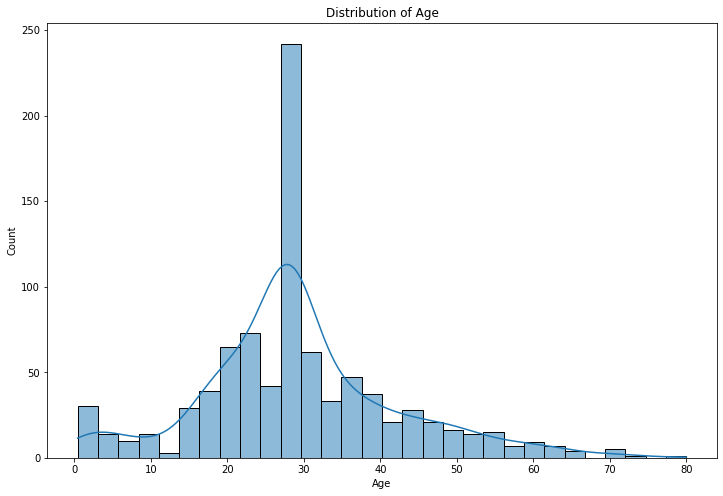

In [54]:
#Age plot
plot_continous(train,'Age')

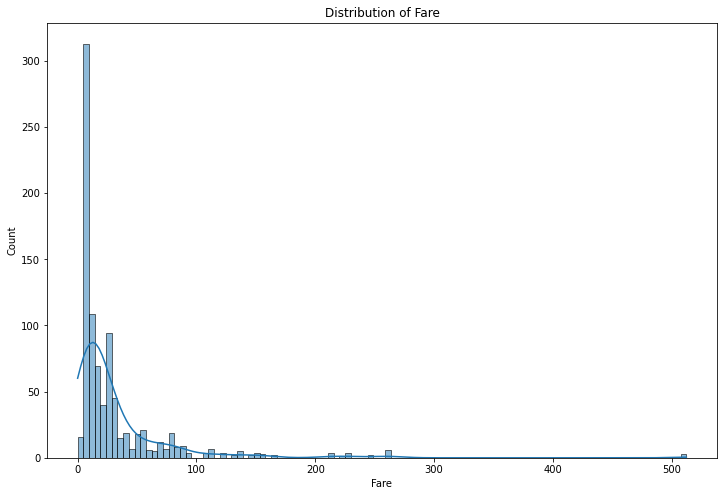

In [55]:
#Age plot
plot_continous(train,'Fare')

### plot for Categorical variables 

In [56]:
def plot_categorical(df,column):
    fig,ax = plt.subplots(figsize=(20,8),ncols=2)
    # Count plot showing counts of each category
    sns.countplot(data = df,x=column,ax=ax[0])
    ax[0].set(title=f'Counts of {column} categories')

    value_counts = df[column].value_counts()
    ax[1].pie(value_counts.values,labels=value_counts.index,autopct = '%1.1f%%')
    ax[1].set(title = f'Pie chart of column {column}')

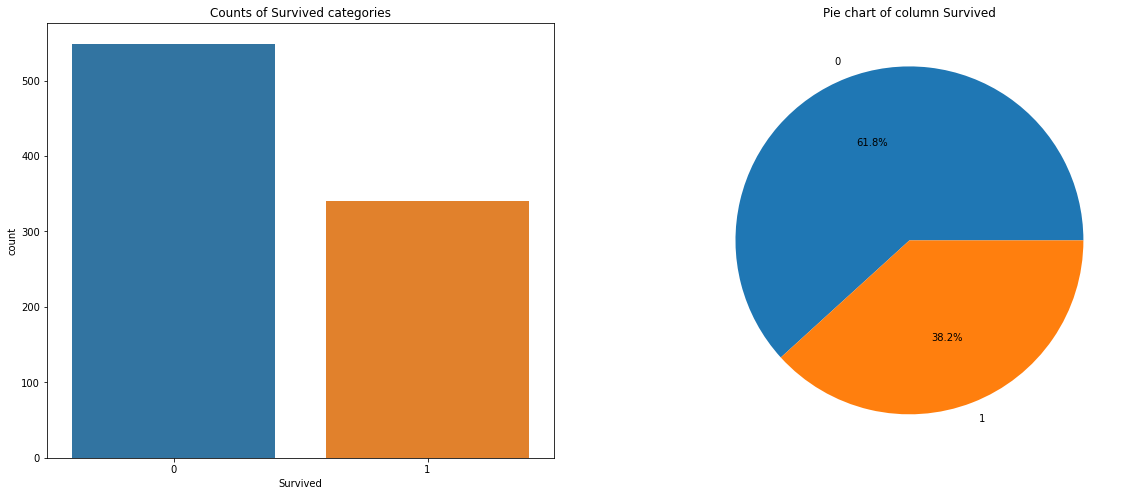

In [57]:
#survived column
plot_categorical(train,'Survived')

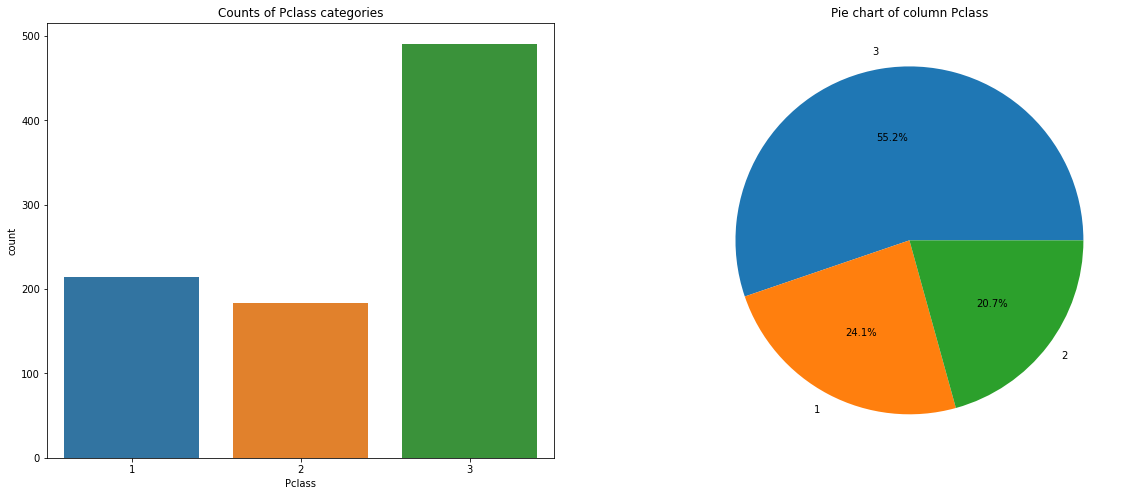

In [58]:
#pclass column
plot_categorical(train,'Pclass')

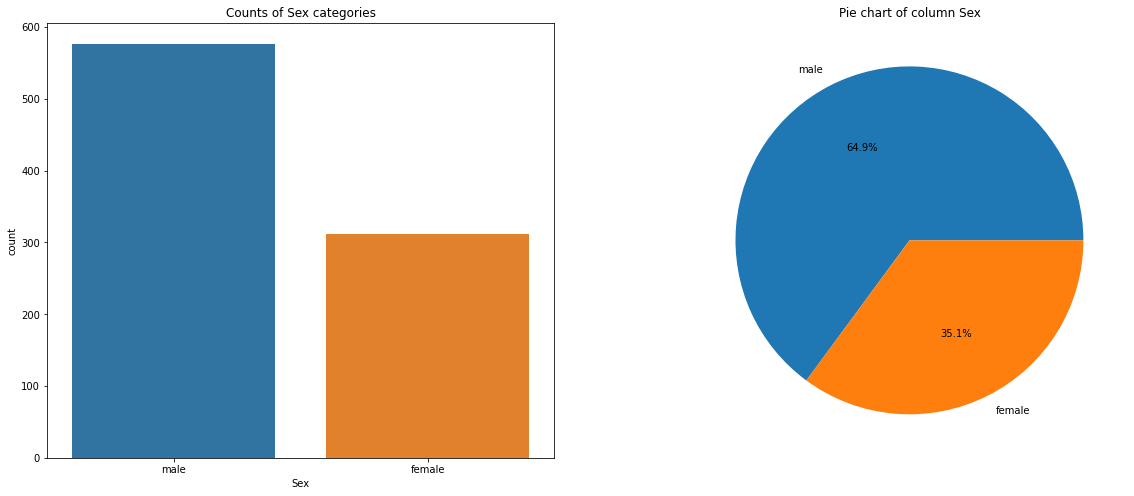

In [59]:
#sex column
plot_categorical(train,'Sex')

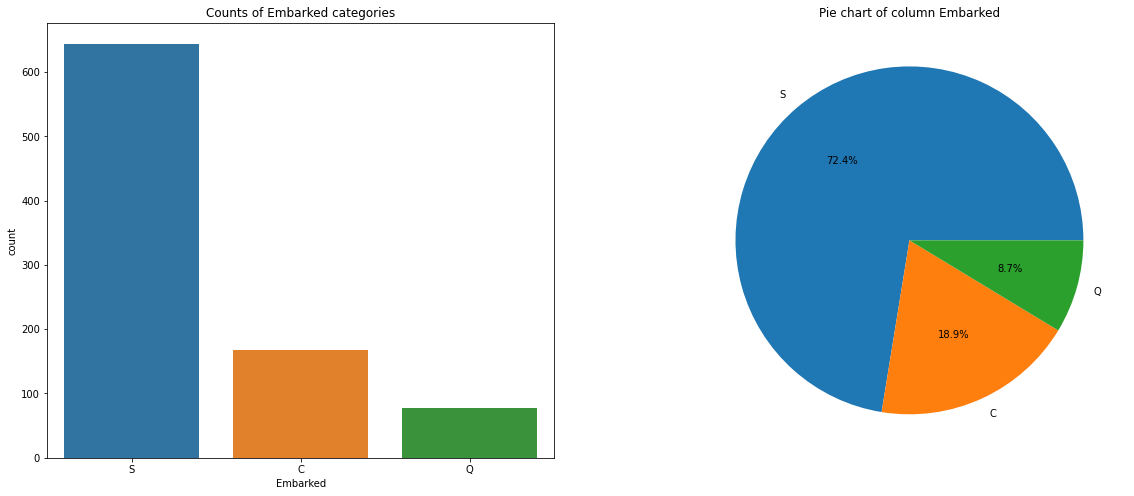

In [60]:
#Embarked column
plot_categorical(train,'Embarked')

### One hot encoding categorical values

In [61]:
categorical =  train.select_dtypes(include='object').drop(columns=['Name','Ticket'])
numerics =  train.drop(categorical.columns,axis=1)

# one hot encoding 
ohe = OneHotEncoder(drop='first',sparse_output=False)
train_encoded = pd.DataFrame(ohe.fit_transform(categorical),columns=ohe.get_feature_names_out(categorical.columns),index=categorical.index)
train_encoded = pd.concat([numerics,train_encoded],axis=1).drop('Ticket',axis=1)

In [62]:
train_encoded

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,7.2500,1.0,0.0,1.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,71.2833,0.0,0.0,0.0
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,7.9250,0.0,0.0,1.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,53.1000,0.0,0.0,1.0
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,8.0500,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",27.0,0,0,13.0000,1.0,0.0,1.0
887,888,1,1,"Graham, Miss. Margaret Edith",19.0,0,0,30.0000,0.0,0.0,1.0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",28.0,1,2,23.4500,0.0,0.0,1.0
889,890,1,1,"Behr, Mr. Karl Howell",26.0,0,0,30.0000,1.0,0.0,0.0


## Modelling

In [63]:
#scaling the data
scaler = StandardScaler()
#predictor values
X = train_encoded.drop(columns=['PassengerId','Survived','Name'])
X_train_scaled = scaler.fit_transform(X)
#target value
y=train_encoded['Survived']

#split data for modelling 
X_train,X_test,y_train,y_test = train_test_split(X_train_scaled,y,test_size=0.3,shuffle=True, random_state=42)

#Logistic regression
linreg = LogisticRegression(solver='saga',class_weight='balanced',C= 0.01, penalty= 'l2', random_state=42)


#Train the model
model_log = linreg.fit(X_train,y_train)
model_log


LogisticRegression(C=0.01, class_weight='balanced', random_state=42,
                   solver='saga')

### clean and encode test data

In [64]:
#Are there missing values in the test dataset
print(f'There are {test.isna().sum()} missing values in the test data')
#check missing values by percentage
print(f'There are {test.isnull().mean()*100}')
#fill missing value in the fare column with median
# test.dropna(subset='Fare',inplace=True)
test_fare_median = test['Fare'].median()
test['Fare'].fillna(test_fare_median,inplace=True)
#drop cabin column
test.drop(columns='Cabin',inplace=True)
#age is skewed we fill with median
test_age_median = test['Age'].median()
test['Age'].fillna(test_age_median,inplace=True)


There are PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64 missing values in the test data
There are PassengerId     0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            20.574163
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.239234
Cabin          78.229665
Embarked        0.000000
dtype: float64


In [65]:
#No missing values now
print(f'missing values after cleaning {test.isna().sum()}')
#No duplicates
test.duplicated().sum()

missing values after cleaning PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64


0

In [66]:
#encode test data
categorical_test =  test.select_dtypes(include='object').drop(columns=['Name','Ticket'])
numerics_test =  test.drop(categorical_test.columns,axis=1)

# one hot encoding 
ohe = OneHotEncoder(drop='first',sparse_output=False)
test_encoded = pd.DataFrame(ohe.fit_transform(categorical_test),columns=ohe.get_feature_names_out(categorical_test.columns),index=categorical_test.index)
# test_encoded = pd.get_dummies(categorical_test,drop_first=True) #using pd.get_dummies
test_encoded = pd.concat([numerics_test,test_encoded],axis=1).drop(columns=['Ticket','Name','PassengerId'],axis=1)

### Predict  data

In [67]:
y_test_predicted = model_log.predict(X_test)
y_train_predicted = model_log.predict(X_train)

### Evaluate model performance

0.852185628742515


'\nhigh Auc meaning our models performs quite well\n'

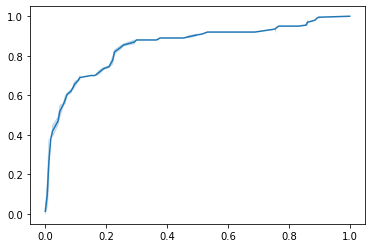

In [68]:
#roc_auc score
y_score = model_log.decision_function(X_test)
fpr,tpr,thereshold = roc_curve(y_test,y_score)
sns.lineplot(x=fpr,y=tpr)
auc = auc(fpr,tpr) ## 0.8624251497005988
print(auc)
#works also
# y_pred = model_log.predict(X_test)
# y_pred_proba = model_log.predict_proba(X_test)[:, 1]

# # Evaluation Metrics
# f1 = f1_score(y_test, y_pred)
# roc_auc = roc_auc_score(y_test, y_pred_proba) 
'''
high Auc meaning our models performs quite well
'''

### mse,r2

In [85]:
mse_train = mean_squared_error(y_train,y_train_predicted)
mse_test = mean_squared_error(y_test,y_test_predicted)
r_Squared =  model_log.score(X_train,y_train)

print(f'mse_train: {mse_train}')
print(f'mse_test: {mse_test}')

print(f'r_Squared: {r_Squared}')

# mse_train: 0.13665594855305466
# mse_test: 0.19101123595505617
# r_Squared: 0.8633440514469454
''' 
model explains 77 % variance shows good peformance
Difference between train and test mse is 0.09 which is small meaning our model generalizes well on unseen data and there is no significant overfitting
'''

mse_train: 0.22347266881028938
mse_test: 0.22846441947565543
r_Squared: 0.7765273311897106


' \nmodel explains 77 % variance shows good peformance\nDifference between train and test mse is 0.09 which is small meaning our model generalizes well on unseen data and there is no significant overfitting\n'

In [70]:
#classification report
print(classification_report(y_test, y_test_predicted))
accuracy = accuracy_score(y_test, y_test_predicted)
precision = precision_score(y_test, y_test_predicted)
recall = recall_score(y_test, y_test_predicted)

print("\nKey Performance Indicators:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

              precision    recall  f1-score   support

           0       0.84      0.78      0.81       167
           1       0.67      0.76      0.71       100

    accuracy                           0.77       267
   macro avg       0.76      0.77      0.76       267
weighted avg       0.78      0.77      0.77       267


Key Performance Indicators:
Accuracy: 0.77
Precision: 0.67
Recall: 0.76


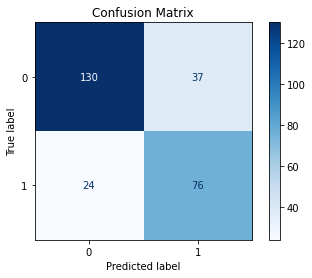

In [71]:
# Confusion Matrix
# Confusion Matrix Visualization
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_test_predicted,
    display_labels=model_log.classes_,
    cmap=plt.cm.Blues
)
plt.title("Confusion Matrix")
plt.show()


### Feature Selection

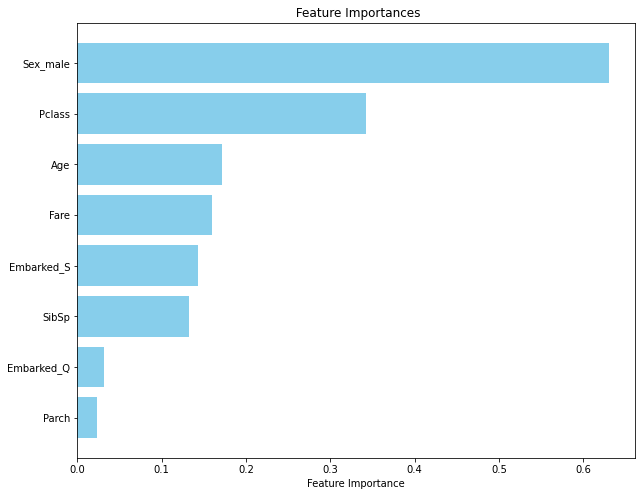

' \nSex,Pclass,Age,Sibsp,Fare most relevant features for our model\n'

In [72]:
#feature importance

#Get the absolute values of the coefficient
feature_importances = np.abs(model_log.coef_).flatten()

#create dataframe for feature importance
importance_df = pd.DataFrame({
    'Feature':X.columns,
    'Importance':feature_importances
})


# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(20)

# Plot the  feature importances
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.xlabel('Feature Importance')
plt.title(' Feature Importances')
plt.show()

''' 
Sex,Pclass,Age,Sibsp,Fare most relevant features for our model
'''

#Feature selection #since we are doing predictive modelling we will use the coef_ method for feature selection
# from sklearn.feature_selection import SelectKBest
# from sklearn.feature_selection import f_classif
# selector = SelectKBest(f_classif, k=4)
# selector.fit_transform(X,y)
# # Get selected feature names
# selected_features = X.columns[selector.get_support()]
# print("Selected Features:", selected_features)

### Function to handle Evaluation metrics


In [73]:
def modelling(model,X_train,X_test,y_train,y_test):

    y_test_predicted = model.predict(X_test)
    y_train_predicted = model.predict(X_train)

    r_Squared_train =  model.score(X_train,y_train)
    r_Squared_test =  model.score(X_test,y_test)

    mse_train = mean_squared_error(y_train,y_train_predicted)
    mse_test = mean_squared_error(y_test,y_test_predicted)

    # y_score = model.decision_function(X_test)
    fpr,tpr,thereshold = roc_curve(y_test,y_score)
    # sns.lineplot(x=fpr,y=tpr)
    y_pred_proba = model_log.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_proba) 
    # roc_auc1 = auc(fpr,tpr) 

    print(f'mse_train: {mse_train}')
    print(f'mse_test: {mse_test}')

    print(f'r_Squared_train: {r_Squared_train}')
    print(f'r_Squared_test: {r_Squared_test}')
    # print(f'roc_auc: {roc_auc1}')
    print(f'roc_auc: {roc_auc}')


    #classification report
    # print("\nclassification_report:")
    # print(classification_report(y_test, y_test_predicted))
    accuracy = accuracy_score(y_test, y_test_predicted)
    precision = precision_score(y_test, y_test_predicted)
    recall = recall_score(y_test, y_test_predicted)
    print('\n----------------\n')
    print("\nKey Performance Indicators:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")

    # Confusion Matrix
    # Confusion Matrix Visualization
    # print("\nConfusionMatrixDisplay:")
    # ConfusionMatrixDisplay.from_predictions(
    #     y_test,
    #     y_test_predicted,
    #     display_labels=model_log.classes_,
    #     cmap=plt.cm.Blues
    # )
    # plt.title("Confusion Matrix")
    # plt.show()

    # return r_Squared_test,mse_test,roc_auc1,roc_auc2

### Check Model with only important features

In [74]:
#Base model
modelling(model_log,X_train,X_test,y_train,y_test)

mse_train: 0.22347266881028938
mse_test: 0.22846441947565543
r_Squared_train: 0.7765273311897106
r_Squared_test: 0.7715355805243446
roc_auc: 0.852185628742515

----------------


Key Performance Indicators:
Accuracy: 0.77
Precision: 0.67
Recall: 0.76


In [75]:
## Model with selected features
#predictor values
X_select = train_encoded[['Pclass','Sex_male','Age','SibSp']]
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X)
#target value
y=train_encoded['Survived']
#split data for modelling 
X_train,X_test,y_train,y_test = train_test_split(X_train_scaled,y,test_size=0.3,shuffle=True, random_state=42)

#Logistic regression
linreg = LogisticRegression(solver='liblinear',class_weight='balanced', C=0.1,random_state=42)

#Train the model
model_log = linreg.fit(X_train,y_train)
model_log
modelling(model_log,X_train,X_test,y_train,y_test) 
'''Selecting features does not improve performance'''

mse_train: 0.22347266881028938
mse_test: 0.19850187265917604
r_Squared_train: 0.7765273311897106
r_Squared_test: 0.8014981273408239
roc_auc: 0.8523652694610778

----------------


Key Performance Indicators:
Accuracy: 0.80
Precision: 0.70
Recall: 0.81


'Selecting features does not improve performance'

### Decision Tree

In [76]:
clf = DecisionTreeClassifier(random_state=42)
X_train,X_test,y_train,y_test = train_test_split(X_train_scaled,y,test_size=0.3,shuffle=True,random_state=42)
#train the model
model_dec = clf.fit(X_train,y_train)
model_dec

#check metrics
modelling(model_dec,X_train,X_test,y_train,y_test)

''' 
overfitting
'''

mse_train: 0.012861736334405145
mse_test: 0.22846441947565543
r_Squared_train: 0.9871382636655949
r_Squared_test: 0.7715355805243446
roc_auc: 0.8523652694610778

----------------


Key Performance Indicators:
Accuracy: 0.77
Precision: 0.69
Recall: 0.72


' \noverfitting\n'

### Random Forest

In [77]:
model_rand = RandomForestClassifier()
X_train,X_test,y_train,y_test = train_test_split(X_train_scaled,y,test_size=0.3,shuffle=True,random_state=42)
model_rand.fit(X_train,y_train)
modelling(model_dec,X_train,X_test,y_train,y_test) 

''' 
Overiftting
'''

mse_train: 0.012861736334405145
mse_test: 0.22846441947565543
r_Squared_train: 0.9871382636655949
r_Squared_test: 0.7715355805243446
roc_auc: 0.8523652694610778

----------------


Key Performance Indicators:
Accuracy: 0.77
Precision: 0.69
Recall: 0.72


' \nOveriftting\n'

## Hyper paramater tuning

In [78]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Split your dataset (replace X and y with your dataset)
X_train, X_test, y_train, y_test = train_test_split(X_train_scaled, y, test_size=0.2, random_state=42)

# Define models and their parameter grids
model_params = {
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=1000),
        'params': {
            'C': [0.01, 0.1, 1, 10, 100],
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear', 'saga']
        }
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(random_state=42),
        'params': {
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 5],
            'criterion': ['gini', 'entropy']
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', 'log2']
        }
    }
}

# Store results
results = []

# Perform Grid Search for each model
for model_name, config in model_params.items():
    print(f"Running GridSearchCV for {model_name}...")
    grid_search = GridSearchCV(estimator=config['model'], param_grid=config['params'], cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    # Save best results
    results.append({
        'model': model_name,
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_
    })
    
    # Evaluate on test data
    y_pred = grid_search.best_estimator_.predict(X_test)
    print(f"Classification Report for {model_name}:\n", classification_report(y_test, y_pred))
    print("\n")

# Display all results
for result in results:
    print(f"Model: {result['model']}")
    print(f"Best Parameters: {result['best_params']}")
    print(f"Best CV Score: {result['best_score']}")
    print("-" * 50)


Running GridSearchCV for Logistic Regression...
Classification Report for Logistic Regression:
               precision    recall  f1-score   support

           0       0.83      0.87      0.85       109
           1       0.78      0.71      0.74        69

    accuracy                           0.81       178
   macro avg       0.80      0.79      0.80       178
weighted avg       0.81      0.81      0.81       178



Running GridSearchCV for Decision Tree...
Classification Report for Decision Tree:
               precision    recall  f1-score   support

           0       0.81      0.88      0.84       109
           1       0.78      0.67      0.72        69

    accuracy                           0.80       178
   macro avg       0.79      0.77      0.78       178
weighted avg       0.80      0.80      0.79       178



Running GridSearchCV for Random Forest...
Classification Report for Random Forest:
               precision    recall  f1-score   support

           0       0.82

### Model with Random Forest which has been selected as the best model

In [79]:
model_rand = RandomForestClassifier(max_depth= None, max_features= 'log2', min_samples_leaf= 1, min_samples_split= 10, n_estimators= 50)
X_train,X_test,y_train,y_test = train_test_split(X_train_scaled,y,test_size=0.3,shuffle=True,random_state=42)
model_rand.fit(X_train,y_train)
modelling(model_dec,X_train,X_test,y_train,y_test) 



mse_train: 0.012861736334405145
mse_test: 0.22846441947565543
r_Squared_train: 0.9871382636655949
r_Squared_test: 0.7715355805243446
roc_auc: 0.8523652694610778

----------------


Key Performance Indicators:
Accuracy: 0.77
Precision: 0.69
Recall: 0.72


In [80]:
#logistic regression
mse_train: 0.22347266881028938
mse_test: 0.19850187265917604
r_Squared_train: 0.7765273311897106
r_Squared_test: 0.8014981273408239
roc_auc: 0.8523652694610778

# ----------------
# Key Performance Indicators:
Accuracy: 0.80
Precision: 0.70
Recall: 0.81

# decision tree
mse_train: 0.012861736334405145
mse_test: 0.22846441947565543
r_Squared_train: 0.9871382636655949
r_Squared_test: 0.7715355805243446
roc_auc: 0.8523652694610778

# ----------------


# Key Performance Indicators:
Accuracy: 0.77
Precision: 0.69
Recall: 0.72

# random forest
mse_train: 0.012861736334405145
mse_test: 0.22846441947565543
r_Squared_train: 0.9871382636655949
r_Squared_test: 0.7715355805243446
roc_auc: 0.8523652694610778

# ----------------


# Key Performance Indicators:
Accuracy: 0.77
Precision: 0.69
Recall: 0.72

In [81]:
'''
Will use logistic regression for modelling
'''


'\nWill use logistic regression for modelling\n'

### Predict test data

In [82]:
X_test_titanic =  scaler.transform(test_encoded)
survival_pred = model_log.predict(X_test_titanic)
survival_pred

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,

In [83]:
test['Survived'] = survival_pred
submission = test[['PassengerId','Survived']]
submission.to_csv('submission.csv',index=False)

In [84]:
test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,S,1
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,27.0,0,0,A.5. 3236,8.0500,S,0
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C,1
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,S,0
416,1308,3,"Ware, Mr. Frederick",male,27.0,0,0,359309,8.0500,S,0
